In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from kyle.sampling.fake_clf import DirichletFC
from kyle.evaluation import EvalStats, compute_accuracy, compute_ECE, compute_expected_max
from kyle.transformations import *

import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)


In [3]:
n_samples = 100000

# Dirichlet fake classifiers

Add explanation about the model and integrals

## Computing properties with integrals

The asymptotic values for ECE and accuracy can be computed through (numerical or analytical)
integration.

In [4]:

n_classes = 3
alpha=[0.2, 0.3, 0.4]

dirichlet_fc = DirichletFC(n_classes, alpha=alpha)

mostly underestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut
Accuracy is 0.87686
ECE is 0.0993425490731012
ece_approx=0.09934254907310103


theoretical_acc=0.8738803675065833 , theoretical_ece=0.09711500702038803


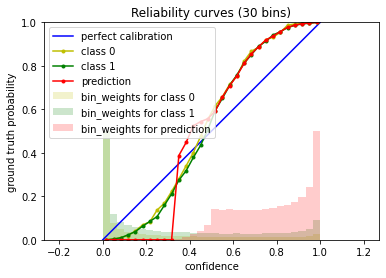

In [5]:
print("mostly underestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut")
transform = PowerLawSimplexAut(np.array([2, 2, 2]))
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
ece_approx = - eval_stats.expected_confidence() + eval_stats.accuracy()
print(f"{ece_approx=}")
eval_stats.plot_reliability_curves([0, 1, EvalStats.TOP_CLASS_LABEL], display_weights=True)


theoretical_acc = compute_accuracy(dirichlet_fc)[0]
theoretical_ece = compute_ECE(dirichlet_fc)[0]
print(f"{theoretical_acc=} , {theoretical_ece=}")



mostly overestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut
Note the variance and the resulting sensitivity to binning
Accuracy is 0.48624


ECE is 0.2926152262421096
ece_approx=0.2919213278242735


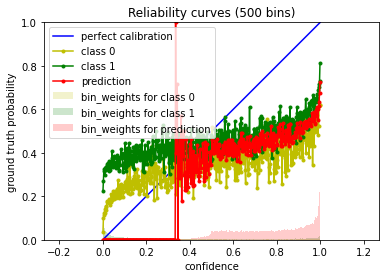

In [6]:
print("mostly overestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut")
print("Note the variance and the resulting sensitivity to binning")

transform = PowerLawSimplexAut(np.array([0.3, 0.1, 0.2]))
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples), bins=500)

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
ece_approx = eval_stats.expected_confidence() - eval_stats.accuracy()
print(f"{ece_approx=}")
eval_stats.plot_reliability_curves([0, 1, EvalStats.TOP_CLASS_LABEL], display_weights=True)


# theoretical_acc = compute_accuracy(dirichlet_fc)[0]
# theoretical_ece = compute_ECE(dirichlet_fc)[0]
# print(f"{theoretical_acc=} , {theoretical_ece=}")


Overestimating predictions with MaxComponent
Accuracy is 0.60376
ECE is 0.17529354007477305


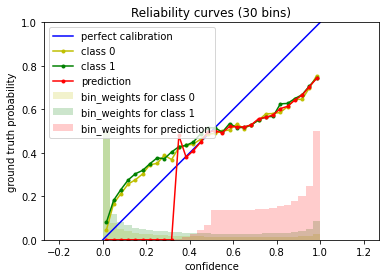

In [7]:
print("Overestimating predictions with MaxComponent")

def overestimating_max(x: np.ndarray):
    x = x.copy()
    mask = x > 1/2
    x[mask] = x[mask] - (1/4 - (1-x[mask])**2)
    return x

transform = MaxComponentSimplexAut(overestimating_max)
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
eval_stats.plot_reliability_curves([0, 1, EvalStats.TOP_CLASS_LABEL], display_weights=True)

# Integrals converge pretty slowly, this takes time
# theoretical_acc = compute_accuracy(dirichlet_fc, opts={"limit": 75})[0]
# theoretical_ece = compute_ECE(dirichlet_fc, opts={"limit": 75})[0]
# print(f"{theoretical_acc=} , {theoretical_ece=}")

# Analytical results

For top-class overconfident classifiers we have

$ECE_i = \int_{A_i} \ (c_i - h_i(\vec c)) \cdot p(\vec c)$

$acc_i = \int_{A_i} \ h_i(\vec c) \cdot p(\vec c)$

In many relevant regimes, the DirichletFC can be approximately regarded as sufficiently confident.
This means we can approximate ECE and accuracy as:

$ECE_i \  \lessapprox \ \int_{\tilde A_i} \ (c_i - h_i(\vec c)) \cdot p(\vec c)$

$acc_i \ \lessapprox \ \int_{\tilde A_i} \ h_i(\vec c) \cdot p(\vec c)$

We can explicitly calculate the first part of the ECE:

$ \int_{\tilde A_i} \ c_i \cdot p(\vec c) = \frac{\alpha_i}{\alpha_0}
\left(1 - (\alpha_0-\alpha_i) \ \beta(1/2;\ \alpha_i + 1, \alpha_0-\alpha_i) \ \binom{\alpha_0}{\alpha_i} \right)$

As expected, when $\alpha_i \rightarrow \alpha_0$, this expression goes to one

The second part depends on the simplex automorphism $h$.
We can sort of compute it for the RestrictedPowerAut and for some MaxComponentSimplexAut.
However, both transforms seem to be rather on the pathological side of things...

mostly underestimating first two classes with RestrictedPowerSimplexAut
Accuracy is 0.71953
ECE is 0.059167102365727586
Theoretical approximation of ECE
0.05897156242616253


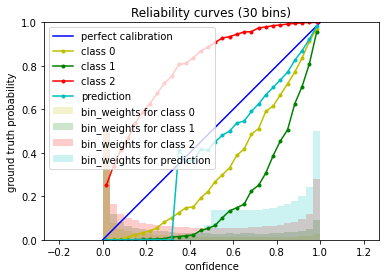

In [8]:
print("mostly underestimating first two classes with RestrictedPowerSimplexAut")

transform = RestrictedPowerSimplexAut(np.array([2, 4]))
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
print("Theoretical approximation of ECE")
print(eval_stats.expected_confidence() - eval_stats.accuracy())
eval_stats.plot_reliability_curves([0, 1, 2, EvalStats.TOP_CLASS_LABEL], display_weights=True)


# theoretical_acc = compute_accuracy(dirichlet_fc)[0]
# theoretical_ece = compute_ECE(dirichlet_fc)[0]
# print(f"{theoretical_acc=} , {theoretical_ece=}")


NOTE: here the ECE completely fails to converge to it's true, continuous value.
This is probably due to the binning-variance, see plots below with 500 bins.
The sharp peak in weights at the end certainly does not help convergence either.



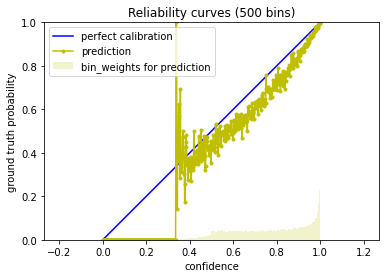

In [9]:
print(f"""
NOTE: here the ECE completely fails to converge to it's true, continuous value.
This is probably due to the binning-variance, see plots below with 500 bins.
The sharp peak in weights at the end certainly does not help convergence either.
""")

eval_stats.set_bins(500)
eval_stats.plot_reliability_curves([EvalStats.TOP_CLASS_LABEL], display_weights=True)

## The Calibration Game

Below are potential 5-classes classifiers that we will use in the calibration game.
They all have roughly the same accuracy but very differing ECEs, corresponding to
different difficulty settings for the game.

In [10]:
n_classes = 5
n_samples = 500000

hardest setting: accuracy 80, ECE 18


Accuracy is 0.798884


ECE is 0.18322050911568274


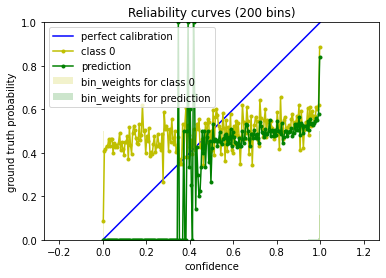

In [11]:
print("hardest setting: accuracy 80, ECE 18")

exponents = np.array([0.05, 0.4, 0.1, 0.2, 0.1]) * 2/3
alpha = np.ones(5) * 1/150

# exponents = np.ones(5) * 1/5
# alpha = np.ones(5) * 1/45

dirichlet_fc = DirichletFC(n_classes, alpha=alpha)
transform = PowerLawSimplexAut(exponents)
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples), bins=200)

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
eval_stats.plot_reliability_curves([0, eval_stats.TOP_CLASS_LABEL], display_weights=True)

medium setting: accuracy 80, ECE 10


Accuracy is 0.7979166666666667


ECE is 0.10638368255948694


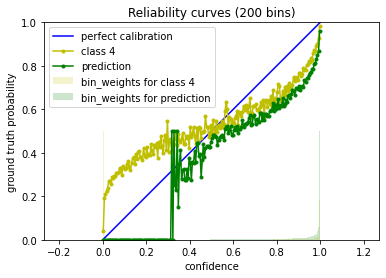

In [12]:
print("medium setting: accuracy 80, ECE 10")

exponents = np.array([0.5, 1, 1, 1, 0.5]) * 1/1.8
alpha = np.array([0.5, 2, 3, 4, 5]) * 1/65

n_samples = 300000
n_classes = 5


dirichlet_fc = DirichletFC(n_classes, alpha=alpha)
transform = PowerLawSimplexAut(exponents)
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples), bins=200)

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
eval_stats.plot_reliability_curves([4, eval_stats.TOP_CLASS_LABEL], display_weights=True)

mostly underestimating all classes (starting at 1/n_classes)


Accuracy is 0.7937466666666667
ECE is 0.002019585186626581


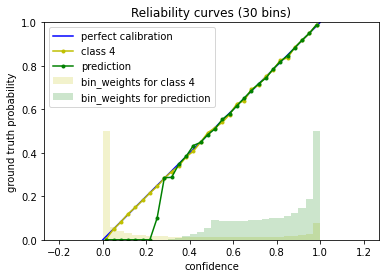

In [13]:
print("mostly underestimating all classes (starting at 1/n_classes)")


# accuracy 80, ECE 0
alpha = np.array([1, 2, 3, 2, 3]) * 1/19

n_samples = 300000
n_classes = 5

dirichlet_fc = DirichletFC(n_classes, alpha=alpha)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
eval_stats.plot_reliability_curves([4, eval_stats.TOP_CLASS_LABEL], display_weights=True)
